In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
import numpy as np
import os
import sys
import func
import fnmatch
import time
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from params import dresden_images_root, train_csv_path, patch_span, \
        patch_num, patches_root, patches_db_path

Found 11775 images belonging to 3 classes.

# Evaluate on test data
184/184 [==============================] - 30s 160ms/step - loss: 0.0037 - accuracy: 0.9988
test loss, test acc: [0.003686473836106198, 0.9987825]

It tooks 18 seconds

index are predictions, columns are ground truth



,Canon_Ixus70,Olympus_mju-1050SW,Nikon_D200
Canon_Ixus70,1513,1,1
Olympus_mju-1050SW,1,1993,8
Nikon_D200,0,0,2883


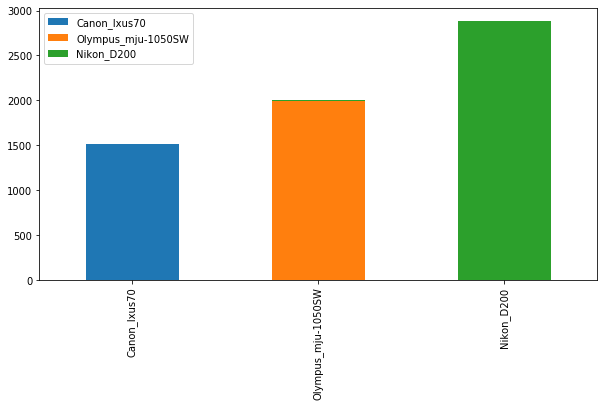

In [4]:
# Define image and batch size
img_height = 256
img_width = 256
batch_size = 64

# Load and Compile the model
model = tf.keras.models.load_model('model.h5')

sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.95, decay=0.0004)

model.compile(
    optimizer=sgd, 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

# Create the Generator
test_data_gen = ImageDataGenerator(preprocessing_function=None,
    rescale=1./255)

# Read the positive test samples.
test_generator = test_data_gen.flow_from_directory(
                  directory = r"./train/test/",
                  target_size=(img_width, img_height), color_mode='grayscale', shuffle=True,
                  batch_size=batch_size, class_mode="categorical")

print('\n# Evaluate on test data')
results = model.evaluate(test_generator)
print('test loss, test acc:', results)

model_list = os.listdir(r'./train/test/')
# generate a histogram, which for every unseen models, how many imgs are classified.
hist, conf, labels = func.evaluate(model_list, test_generator, model, index=model_list, columns=model_list, title=None, num_batch=100)

The mean of the confidence is: 



,Canon_Ixus70,Olympus_mju-1050SW,Nikon_D200
labels,,,
0.0,0.998384,0.000901,0.000715
1.0,0.002133,0.992983,0.004884
2.0,0.000664,0.000534,0.998802


The standard deviation of the confidence is: 



,Canon_Ixus70,Olympus_mju-1050SW,Nikon_D200
labels,,,
0.0,0.031417,0.025734,0.017439
1.0,0.028836,0.065568,0.049298
2.0,0.008076,0.006336,0.010945


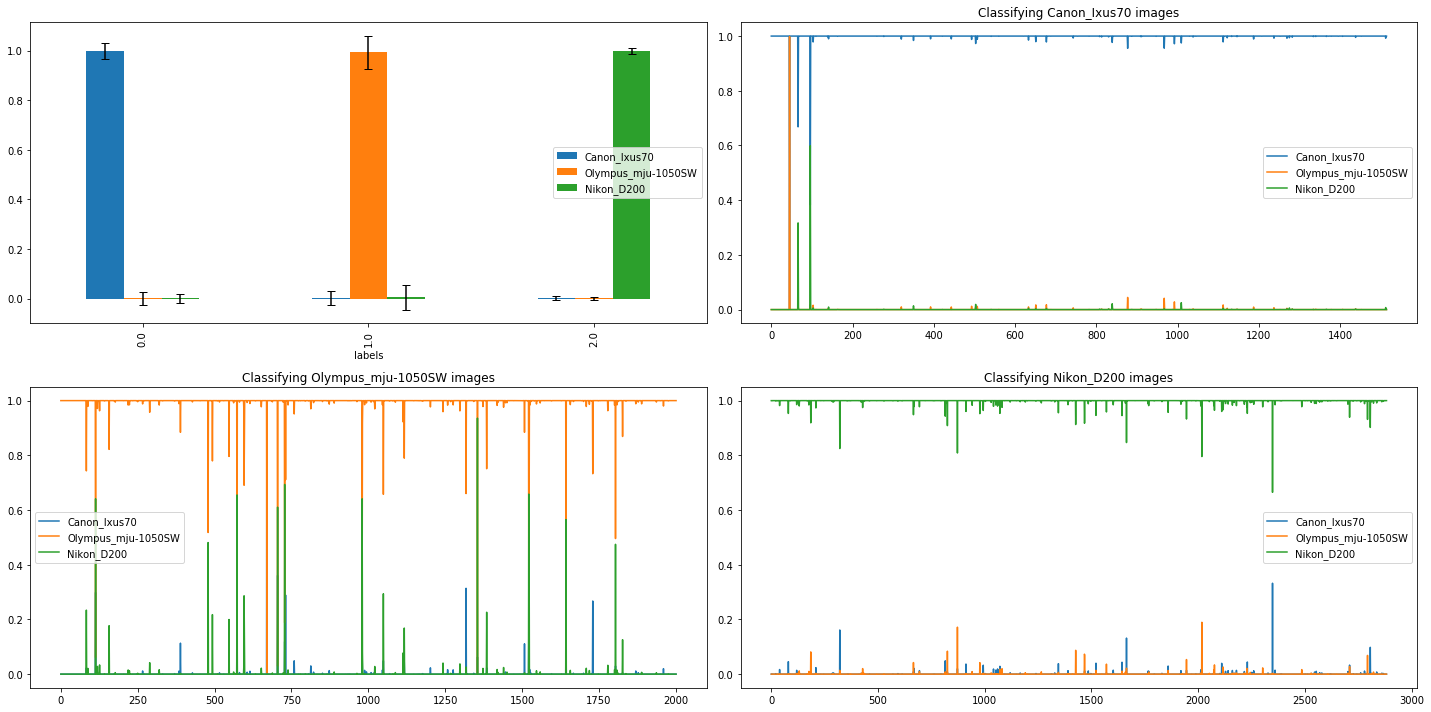

In [5]:
labels = np.hstack((labels))
conf = np.vstack((conf))

df = pd.DataFrame(np.hstack((np.expand_dims(labels, axis=1), conf)), columns=['labels']+model_list)
print('The mean of the confidence is: \n')
mean = df.groupby(['labels']).mean()
display(mean)
print('The standard deviation of the confidence is: \n')
error = df.groupby(['labels']).std()
display(error)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
mean.plot.bar(yerr=error, ax=axes[0,0], capsize=4)

# for all the images' real label is a certain camera, for example Canon_Ixus70, 
# how does these images are classified ? The magnitude of the histogram indicate how
# sure is the model classified the image as one camera(show by color)
graph = {0:axes[0,1], 1:axes[1,0], 2:axes[1, 1]}
for i in range(len(model_list)):
    weights = []
    idx = np.hstack(np.argwhere(labels==i))
    for j in range(len(model_list)):
        weights.append([i[j] for i in conf[idx]])
    df = pd.DataFrame(np.array(weights).transpose(), columns=model_list)
    df.plot( title='Classifying ' + model_list[i] + ' images', ax=graph[i])
plt.tight_layout()

In [6]:
# img_list = []
# for d in [r'./train/test/' + model for model in model_list]:
#     img_list += os.listdir(d) 

# img_path = np.random.choice(img_list, 1)[0]
# img_brand_model = '_'.join(img_path.split('_')[0:2])
# labels = [img_brand_model] * patch_num

# patches_name = fnmatch.filter(img_list, '_'.join(img_path.split('_')[0:-1]) + '*')
# patches_name = [os.path.join('train/test', img_brand_model, patch) for patch in patches_name]

# patches = np.zeros((patch_num, 256, 256))
# for i in range(patch_num):
#     patches[i] = io.imread(patches_name[i])

# # Read the positive test samples.
# img_generator = test_data_gen.flow(np.expand_dims(patches, 3), labels, batch_size=25)

# def plotImages(images_arr):
#     fig, axes = plt.subplots(5, 5, figsize=(20,20))
#     axes = axes.flatten()
#     for img, ax in zip(images_arr, axes):
#         ax.imshow(img[:,:,0], cmap='gray')
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

# plotImages(next(img_generator)[0][:5])

# hist = [0, 0, 0]
# pred = model.predict(img_generator)

# for i in range(patch_num):
#     label = np.argmax(pred[i])
#     hist[label] += 1
    
# print(model_list)
# print(img_brand_model)
# print(hist)